## Classificador binário para características morfométricas de núcleo/citoplasma de células cervicais 

In [1]:
#!pip install pyefd

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#import sys
#sys.path.insert(0,"/content/drive/MyDrive/shape_based_CRIC_Hclassifier")

In [4]:
import numpy as np
import pandas as pd 
from math import sqrt
import os
import sys
import csv
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow 
from skimage import morphology, measure
from skimage.draw import polygon, polygon_perimeter
from scipy.spatial.distance import cdist
from scipy.stats import kurtosis

import pyefd
from pyefd import elliptic_fourier_descriptors, normalize_efd

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import feature_selection as fs
from sklearn import preprocessing

from datetime import datetime

# pay attention to capitalization below!
from spFSR import SpFSR
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE, BorderlineSMOTE

from itertools import cycle
from random import randint
from random import sample

import xgboost as xgb 

import functions, shapeFeatures

c:\python39\lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: p is an invalid version and will not be supported in a future release
  warnings.warn(


In [5]:
Bethesda_classes = {'Normal':0, 'ASC-US':1, 'ASC-H':2, 'LSIL':3,'HSIL':4, 'Invasive Carcinoma':5} 
Bethesda_idx_classes = {0: 'Normal', 1:'ASC-US', 2:'ASC-H', 3:'LSIL',4: 'HSIL', 5:'Invasive Carcinoma'} 

### Lê arquivo (features):

In [6]:
N_EFD_COEFFS = 20

In [7]:
#df = pd.read_csv('/content/drive/MyDrive/shape_based_CRIC_Hclassifier/dataCRIC.csv', sep='|', header=0)
df = pd.read_csv('dataCRIC.csv', sep='|', header=0)
df = shapeFeatures.normalize_dataset(df, n_efd_coeffs= N_EFD_COEFFS)
df

,image_id,cell_id,areaN,eccenN,extentN,periN,maxAxN,minAxN,compacN,circuN,...,efdC73,efdC74,efdC75,efdC76,efdC77,ratio_NC,ratio_NC_per,ratio_NC_hArea,nucleus_position,bethesda
0,1.0,14796.0,0.007403,0.606414,0.842276,0.031326,0.036711,0.083827,0.024126,0.863522,...,0.156532,0.321490,0.859931,0.382225,0.302311,0.017236,0.115646,0.016730,0.099098,0.0
1,1.0,14797.0,0.009371,0.541484,0.808102,0.035945,0.039493,0.095649,0.018763,0.891071,...,0.150931,0.317850,0.859539,0.369221,0.299938,0.010656,0.089517,0.010168,0.121456,0.0
2,1.0,14798.0,0.007275,0.313794,0.884418,0.029457,0.025365,0.097062,0.018895,0.890378,...,0.153458,0.315454,0.861978,0.367980,0.302076,0.007400,0.073961,0.006897,0.043773,0.0
3,1.0,14799.0,0.010570,0.489270,0.778201,0.040199,0.040900,0.103428,0.021001,0.879403,...,0.157254,0.319562,0.860312,0.382943,0.303682,0.028309,0.154784,0.027752,0.128927,0.0
4,1.0,14801.0,0.009115,0.296366,0.842276,0.036826,0.031283,0.106376,0.024456,0.861871,...,0.147193,0.314554,0.860292,0.359672,0.300094,0.021569,0.129992,0.020738,0.069245,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228,399.0,11539.0,0.028927,0.838629,0.579720,0.094256,0.134656,0.118369,0.041270,0.784196,...,0.152113,0.318217,0.859606,0.370535,0.299400,0.206211,0.149094,0.085315,1.943974,5.0
3229,399.0,11540.0,0.025333,0.874227,0.645532,0.094611,0.135676,0.100778,0.064959,0.692461,...,0.150010,0.322108,0.859366,0.375599,0.300755,0.245537,0.247086,0.136756,0.916374,5.0
3230,400.0,11535.0,0.017031,0.910741,0.390863,0.092280,0.136377,0.078990,0.131860,0.507358,...,0.153944,0.319972,0.860379,0.372458,0.303245,0.191508,0.471092,0.188343,0.326252,5.0
3231,400.0,11536.0,0.020797,0.949322,0.528816,0.105709,0.169029,0.065965,0.137720,0.494794,...,0.151898,0.320620,0.859608,0.370771,0.299599,0.111823,0.078186,0.023058,3.177247,5.0


In [8]:
# Separa dados por classe de maneira balanceada:
data_normal = df[df['bethesda'] == 0].copy()
data_normal.set_index((i for i in range(data_normal.shape[0])), inplace=True)

data_ascus = df[df['bethesda'] == 1].copy()
data_ascus.set_index((i for i in range(data_ascus.shape[0])), inplace=True)

data_asch = df[df['bethesda'] == 2].copy()
data_asch.set_index((i for i in range(data_asch.shape[0])), inplace=True)

data_lsil = df[df['bethesda'] == 3].copy()
data_lsil.set_index((i for i in range(data_lsil.shape[0])), inplace=True)

data_hsil = df[df['bethesda'] == 4].copy()
data_hsil.set_index((i for i in range(data_hsil.shape[0])), inplace=True)

data_car = df[df['bethesda'] == 5].copy()
data_car.set_index((i for i in range(data_car.shape[0])), inplace=True)

print("--- Totais por classe --- ")               
print("Normal...: ", data_normal.values.shape[0])               
print("ASC-Us...: ", data_ascus.values.shape[0])               
print("ASC-H....: ", data_asch.values.shape[0])               
print("LSIL.....: ", data_lsil.values.shape[0])               
print("HSIL.....: ", data_hsil.values.shape[0])               
print("Carcinoma: ", data_car.values.shape[0]) 
 

--- Totais por classe --- 
Normal...:  862
ASC-Us...:  286
ASC-H....:  536
LSIL.....:  598
HSIL.....:  874
Carcinoma:  77


#### Gera dataframes: dados (data), classes (target) e Ids (image/cell)

In [9]:
# Monta base (data, target, image/cells ids)
data, target, image_cells_ids= functions.get_database_data_targe_ids(data_normal, data_ascus, 
                       data_lsil, data_asch, data_hsil,data_car,
                       functions.list_all_features(N_EFD_COEFFS))
 

In [10]:
## Parâmetros resultantes de gridsearch dos modelos (tuning.ipynb)
svm_param =  {'C': 100, 'kernel': 'linear'}
rf_param = {'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 50}
xgb_param = {'learning_rate': 0.1, 'n_estimators': 86, 'max_depth': 9, 'min_child_weight':1,
              'gamma':0, 'subsample':0.9, 'colsample_bytree':0.7, 'reg_alpha': 0.001}

In [11]:
classifiers = ['SVM', 'RF', 'XGBoost']
params = [svm_param, rf_param, xgb_param]
features = functions.list_all_EFD_features(N_EFD_COEFFS)
print(f'Nº total de de features: {len(features)}')

Nº total de de features: 154


## Experiment:   classifiers bin/ter/bethesda only EFD's to N+C
only selected EFD features to N + C

In [12]:
best_features_SPFSR_bin = ['efdN74','efdN76','efdN75','efdN6','efdN73','efdN71','efdC71','efdN1',
                           'efdN61','efdN14','efdC70','efdC62','efdC75','efdN70','efdN69','efdC54',
                           'efdC55','efdC58','efdC42','efdC66','efdC4','efdN34','efdN72','efdC67',
                           'efdC46','efdN66','efdC74','efdN67','efdC28','efdN62']
best_features_SPFSR_ter = ['efdN75','efdC70','efdC8','efdC54','efdC72','efdN71','efdC58','efdC66',
                           'efdC16','efdN74','efdC75','efdN73','efdN67','efdC6','efdN76','efdC20',
                           'efdC74','efdC2','efdC28','efdC26','efdN6','efdC18','efdC12','efdN1',
                           'efdC71','efdC38','efdN42','efdC14','efdN14','efdN20']
best_features_SPFSR_bet = ['efdN75','efdC8','efdC14','efdN74','efdN76','efdC58','efdC66','efdC74',
                           'efdN12','efdC70','efdN6','efdC20','efdC26','efdC71','efdC46','efdC28',
                           'efdN71','efdC55','efdN8','efdC36','efdC67','efdC42','efdN77','efdN70',
                           'efdC30','efdC65','efdC62','efdC76','efdN4','efdC22']

In [13]:
len(best_features_SPFSR_bin), len(best_features_SPFSR_ter), len(best_features_SPFSR_bet)

(30, 30, 30)

In [14]:
start_t = functions.timer()

### Cross-validation:  Normal vs Anormal

In [15]:
labels_list = []
conf_matrix_list = []
roc_curve_list = []

# Data_frame de resultados
results = pd.DataFrame(columns=['Tipo', 'Model', 'Features', 'Acurácia', 'Precisão', 'Sensibil' , 'Falso Pos', 'Especif', 'F1_measure'])
classifiers = ['SVM', 'RF', 'XGBoost']
features_desc= "Selected only EFD features for N+C" 

N_SPLITS = 10 

In [16]:

for ci in range(3):
    # Executa cross-validation e mostra curvas ROC
    cv = StratifiedKFold(n_splits= N_SPLITS)

    
    accs = np.zeros((N_SPLITS), dtype = np.float64)
    precs = np.zeros((N_SPLITS), dtype = np.float64)
    recs = np.zeros((N_SPLITS), dtype = np.float64)
    specs = np.zeros((N_SPLITS), dtype = np.float64)
    f1_scores = np.zeros((N_SPLITS), dtype = np.float64)
    aucs = np.zeros((N_SPLITS), dtype = np.float64)
    
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)

    preds_y = np.zeros(target.shape[0])

    ## Ajusta features para treino e teste
    X = data[best_features_SPFSR_bin].values
    data_y = target['binary'].values

    model = functions.getModel(params= params[ci], classifier = classifiers[ci], class_type = 'binary')
    for i, (train, test) in enumerate(cv.split(X, data_y)):
        # Ajusta modelo:
        metric, model = functions.fit_model(X[train], data_y[train], model, cls_type=1, smote=0)    

        # Predição:
        pred_y = model.predict(X[test])
        prob_y = model.predict_proba(X[test])

        #Registra predições:
        preds_y[test] = pred_y

        # Calcula e registra métricas p/ fold:
        accs[i] = functions.calc_metric(data_y[test], pred_y, metric_type='acc', class_type='binary', classes=[0,1])
        precs[i] = functions.calc_metric(data_y[test], pred_y, metric_type='prec',class_type='binary', classes=[0,1])                
        recs[i] = functions.calc_metric(data_y[test], pred_y, metric_type='rec',class_type='binary', classes=[0,1])                
        specs[i] = functions.calc_metric(data_y[test], pred_y, metric_type='spec',class_type='binary', classes=[0,1])                
        f1_scores[i] = functions.calc_metric(data_y[test], pred_y, metric_type='f1_score',class_type='binary', classes=[0,1])        

        # Calcula curva_roc e AUC:
        prob = prob_y[:, 1]
        fpr, tpr, thresholds = roc_curve(data_y[test], prob)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs[i]= auc(mean_fpr, interp_tpr)

    ## Registra resultados (dataframe):
    metrics = {'acc': np.mean(accs), 'prec': np.mean(precs), 'rec': np.mean(recs), 
               'spec': np.mean(specs), 'f1_score': np.mean(f1_scores)}                                      
    functions.fill_line_metrics_CV(classifiers[ci], features_desc, ci, metrics, results, class_type='binary')

    # Calcula e registra curva ROC (média CV) e confmatrix 
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    roc_curve_list.append((mean_fpr, mean_tpr))
    label = r"Mean ROC (AUC %s= %0.4f $\pm$ %0.4f)" % ((classifiers[ci]+"-binary "), mean_auc, std_auc)
    labels_list.append(label)

    conf_matrix_list.append((data_y, preds_y, features_desc + "- "+classifiers[ci]))
 
                  


### Resultados:

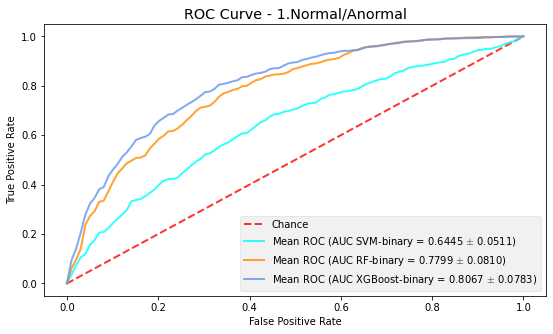

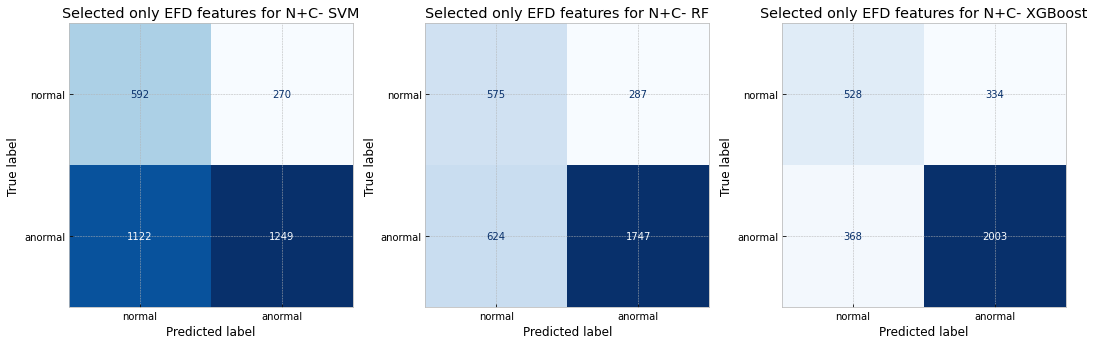

,Tipo,Model,Features,Acurácia,Precisão,Sensibil,Falso Pos,Especif,F1_measure
0,binary,SVM,Selected only EFD features for N+C,0.5695,0.8224,0.5268,0.3130,0.6870,0.6417
1,binary,RF,Selected only EFD features for N+C,0.7183,0.8579,0.7368,0.3327,0.6673,0.7902
2,binary,XGBoost,Selected only EFD features for N+C,0.7829,0.8571,0.8448,0.3873,0.6127,0.8501


In [17]:
# Acumula Matrizes de confusão:
functions.plot_roc_curve_CV(roc_curve_list, labels_list, title = "ROC Curve - 1.Normal/Anormal")
functions.plot_conf_matrix(conf_matrix_list, lbls=[0,1], disp_lbls=['normal', 'anormal'])
results


### Classificador ternário

In [18]:
labels_list = []
conf_matrix_list = []
roc_curve_list = []

# Data_frame de resultados
results = pd.DataFrame(columns=['Tipo', 'Model', 'Features', 'Acurácia', 'Precisão', 'Sensibil' , 'Falso Pos', 'Especif', 'F1_measure'])

In [19]:
for ci in range(3):
    # Executa cross-validation e mostra curvas ROC
    cv = StratifiedKFold(n_splits= N_SPLITS)
    
    accs = np.zeros((N_SPLITS), dtype = np.float64)
    precs = np.zeros((N_SPLITS), dtype = np.float64)
    recs = np.zeros((N_SPLITS), dtype = np.float64)
    specs = np.zeros((N_SPLITS), dtype = np.float64)
    f1_scores = np.zeros((N_SPLITS), dtype = np.float64)
    aucs = np.zeros((N_SPLITS), dtype = np.float64)
    
    preds_y = np.zeros(target.shape[0])

    ## Ajusta features para treino e teste
    X = data[best_features_SPFSR_ter].values
    data_y = target['ternary'].values

    model = functions.getModel(params= params[ci], classifier = classifiers[ci], class_type = 'multiclass')
    for i, (train, test) in enumerate(cv.split(X, data_y)):
        # Ajusta modelo:
        metric, model = functions.fit_model(X[train], data_y[train], model, cls_type=1, smote=0)    

        # Predição:
        pred_y = model.predict(X[test])
        prob_y = model.predict_proba(X[test])

        #Registra predições:
        preds_y[test] = pred_y

        # Calcula e registra métricas p/ fold:
        accs[i] = functions.calc_metric(data_y[test], pred_y, metric_type='acc', class_type='multiclass', classes=[0,1,2])
        precs[i] = functions.calc_metric(data_y[test], pred_y, metric_type='prec',class_type='multiclass', classes=[0,1,2])                
        recs[i] = functions.calc_metric(data_y[test], pred_y, metric_type='rec',class_type='multiclass', classes=[0,1,2])                
        specs[i] = functions.calc_metric(data_y[test], pred_y, metric_type='spec',class_type='multiclass', classes=[0,1,2])                
        f1_scores[i] = functions.calc_metric(data_y[test], pred_y, metric_type='f1_score',class_type='multiclass', classes=[0,1,2])        


    ## Registra resultados (dataframe):
    metrics = {'acc': np.mean(accs), 'prec': np.mean(precs), 'rec': np.mean(recs), 
               'spec': np.mean(specs), 'f1_score': np.mean(f1_scores)}                                      
    functions.fill_line_metrics_CV(classifiers[ci], features_desc, ci, metrics, results, class_type='ternary')

    # Registra confmatrix: 
    conf_matrix_list.append((data_y, preds_y, features_desc + "- "+classifiers[ci]))
 
                  

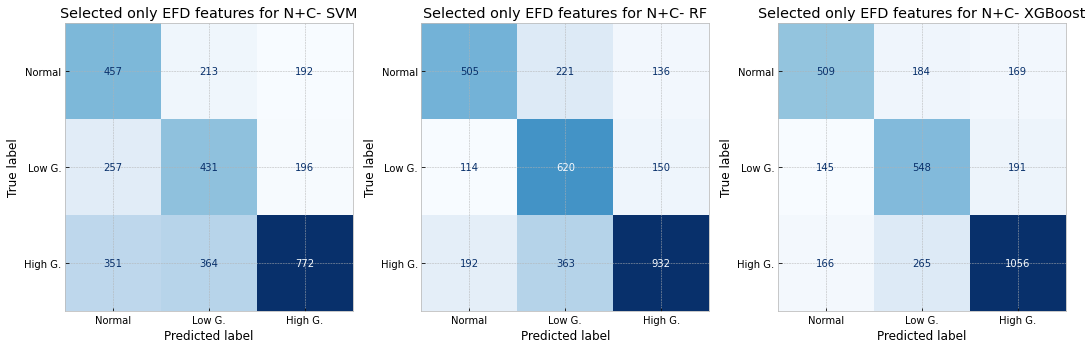

,Tipo,Model,Features,Acurácia,Precisão,Sensibil,Falso Pos,Especif,F1_measure
0,ternary,SVM,Selected only EFD features for N+C,0.5135,0.5371,0.5135,0.2414,0.7586,0.5180
1,ternary,RF,Selected only EFD features for N+C,0.6363,0.6588,0.6363,0.1805,0.8195,0.6383
2,ternary,XGBoost,Selected only EFD features for N+C,0.6536,0.6609,0.6536,0.1762,0.8238,0.6539


In [20]:
# Acumula Matrizes de confusão:
functions.plot_conf_matrix(conf_matrix_list, lbls=[0,1,2], disp_lbls=['Normal', 'Low G.','High G.'])
results

### Classificação Bethesda:

In [21]:
labels_list = []
conf_matrix_list = []
roc_curve_list = []

# Data_frame de resultados
results = pd.DataFrame(columns=['Tipo', 'Model', 'Features', 'Acurácia', 'Precisão', 'Sensibil' , 'Falso Pos', 'Especif', 'F1_measure'])

In [22]:
for ci in range(3):
    # Executa cross-validation e mostra curvas ROC
    cv = StratifiedKFold(n_splits= N_SPLITS)
    
    accs = np.zeros((N_SPLITS), dtype = np.float64)
    precs = np.zeros((N_SPLITS), dtype = np.float64)
    recs = np.zeros((N_SPLITS), dtype = np.float64)
    specs = np.zeros((N_SPLITS), dtype = np.float64)
    f1_scores = np.zeros((N_SPLITS), dtype = np.float64)
    aucs = np.zeros((N_SPLITS), dtype = np.float64)
    
    preds_y = np.zeros(target.shape[0])

    ## Ajusta features para treino e teste
    X = data[best_features_SPFSR_bet].values
    data_y = target['bethesda'].values


    model = functions.getModel(params= params[ci], classifier = classifiers[ci], class_type = 'multiclass')
    for i, (train, test) in enumerate(cv.split(X, data_y)):
        # Ajusta modelo:
        metric, model = functions.fit_model(X[train], data_y[train], model, cls_type=1, smote=1)    

        # Predição:
        pred_y = model.predict(X[test])
        prob_y = model.predict_proba(X[test])

        #Registra predições:
        preds_y[test] = pred_y

        # Calcula e registra métricas p/ fold:
        accs[i] = functions.calc_metric(data_y[test], pred_y, metric_type='acc', class_type='multiclass', classes=[0,1,2,3,4,5])
        precs[i] = functions.calc_metric(data_y[test], pred_y, metric_type='prec',class_type='multiclass', classes=[0,1,2,3,4,5])                
        recs[i] = functions.calc_metric(data_y[test], pred_y, metric_type='rec',class_type='multiclass', classes=[0,1,2,3,4,5])                
        specs[i] = functions.calc_metric(data_y[test], pred_y, metric_type='spec',class_type='multiclass', classes=[0,1,2,3,4,5])                
        f1_scores[i] = functions.calc_metric(data_y[test], pred_y, metric_type='f1_score',class_type='multiclass', classes=[0,1,2,3,4,5])        


    ## Registra resultados (dataframe):
    metrics = {'acc': np.mean(accs), 'prec': np.mean(precs), 'rec': np.mean(recs), 
               'spec': np.mean(specs), 'f1_score': np.mean(f1_scores)}                                      
    functions.fill_line_metrics_CV(classifiers[ci], features_desc, ci, metrics, results, class_type='bethesda')

    # Registra confmatrix: 
    conf_matrix_list.append((data_y, preds_y, features_desc + "- "+classifiers[ci]))
 
                  

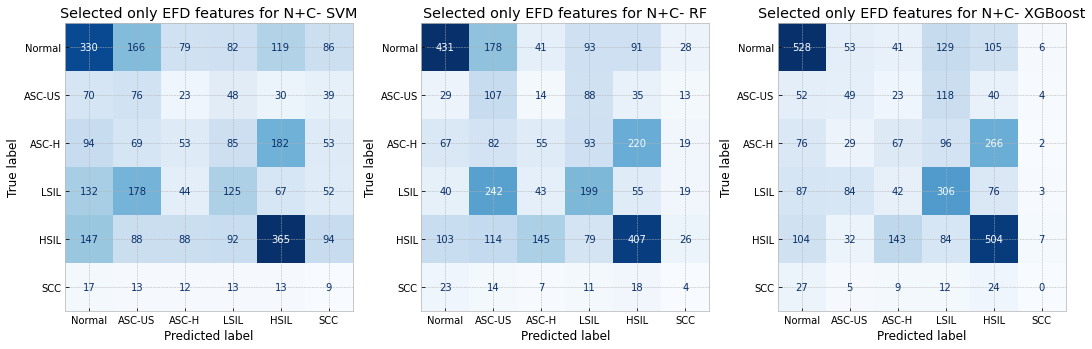


 Time taken: 0 hours 9 minutes and 40.76 seconds.


,Tipo,Model,Features,Acurácia,Precisão,Sensibil,Falso Pos,Especif,F1_measure
0,bethesda,SVM,Selected only EFD features for N+C,0.2964,0.3343,0.2964,0.1430,0.8570,0.3073
1,bethesda,RF,Selected only EFD features for N+C,0.3721,0.4115,0.3721,0.1277,0.8723,0.3811
2,bethesda,XGBoost,Selected only EFD features for N+C,0.4498,0.4230,0.4498,0.1168,0.8832,0.4314


In [23]:
# Acumula Matrizes de confusão:
functions.plot_conf_matrix(conf_matrix_list, lbls=[0,1,2,3,4,5], disp_lbls=['Normal', 'ASC-US','ASC-H','LSIL', 'HSIL', 'SCC'])
functions.timer(start_t)
results